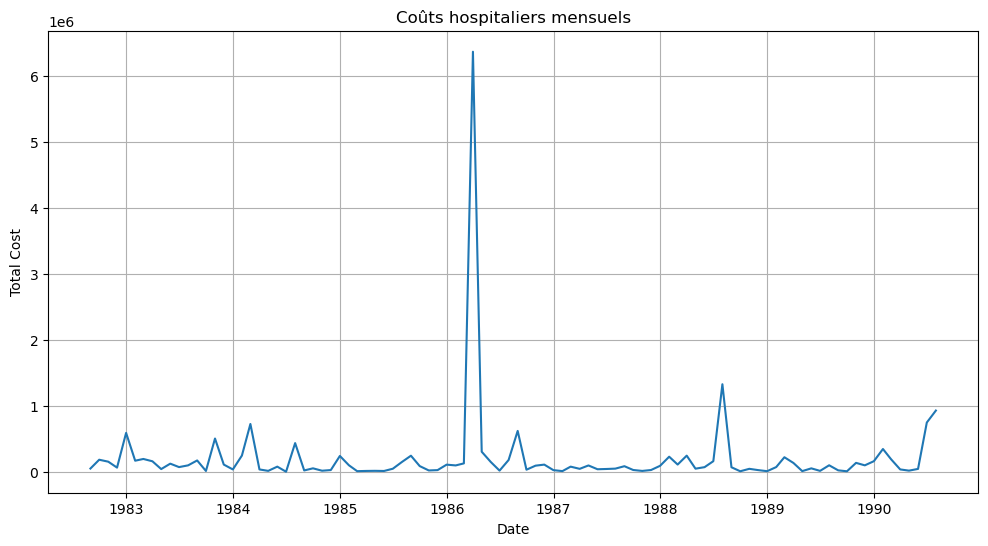

Augmented Dickey-Fuller Test: Total Cost Mensuel
ADF Test Statistic : -9.342269781056475
p-value : 8.732428364043491e-16
#Lags Used : 0
Number of Observations Used : 95
‚úÖ La s√©rie est stationnaire.
Augmented Dickey-Fuller Test: Total Cost Mensuel diff√©renci√©
ADF Test Statistic : -8.391139170148925
p-value : 2.364931802836916e-13
#Lags Used : 3
Number of Observations Used : 91
‚úÖ La s√©rie est stationnaire.


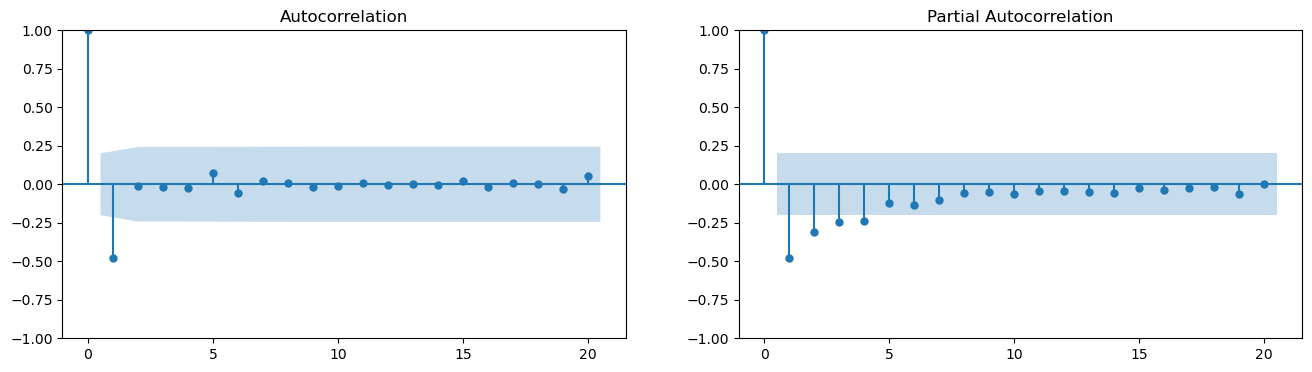

                               SARIMAX Results                                
Dep. Variable:             total_cost   No. Observations:                   96
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1412.476
Date:                Mon, 28 Apr 2025   AIC                           2830.951
Time:                        01:10:33   BIC                           2838.613
Sample:                    08-31-1982   HQIC                          2834.047
                         - 07-31-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0330      0.484      0.068      0.946      -0.916       0.982
ma.L1         -0.9899      0.040    -24.751      0.000      -1.068      -0.911
sigma2      5.875e+11   1.51e-13   3.89e+24      0.0

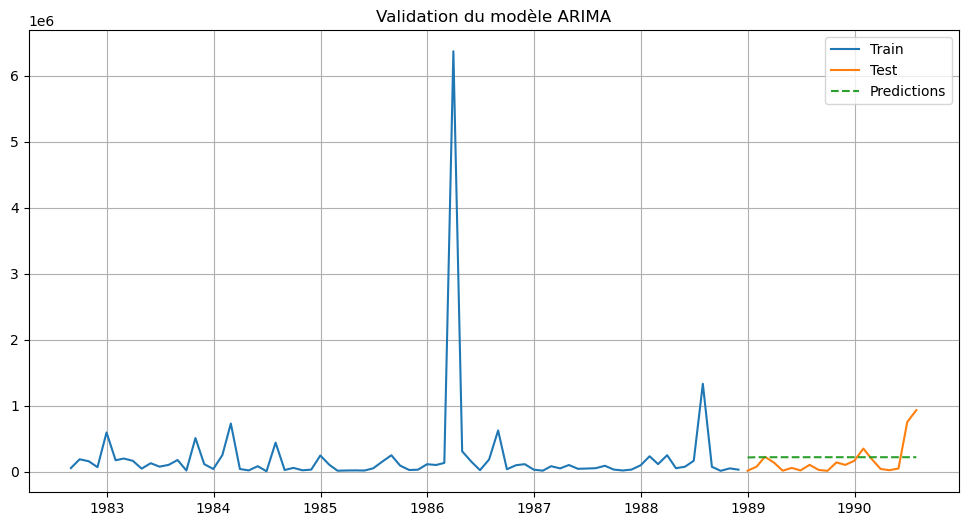

Mean Squared Error sur la p√©riode de test : 59997498643.59


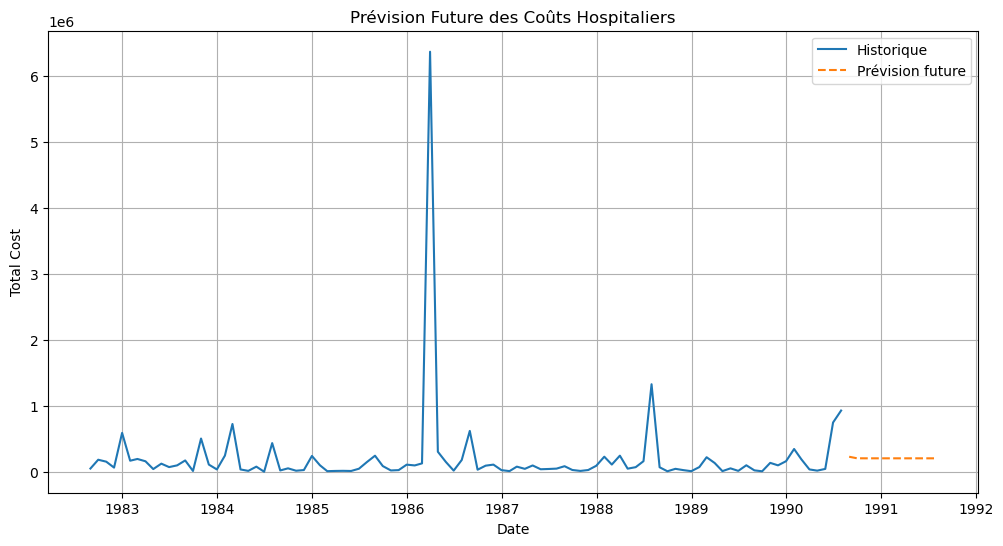

‚úÖ Pr√©dictions futures sauvegard√©es dans 'forecast_costs_arima.csv' pour Power BI !


In [8]:
# üì¶ Imports n√©cessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import pandas as pd

# üì• 1. Charger les donn√©es
factures = pd.read_csv(r'C:\Users\User\data\fact_facture.csv')
admissions = pd.read_csv(r'C:\Users\User\OneDrive\Bureau\Pi4emeBi\health_care_database\ADMISSIONS.csv')


# üîÑ 2. Fusionner et pr√©paration
df = pd.merge(factures, admissions, on='hadm_id', how='left')
df['admittime'] = pd.to_datetime(df['admittime'], errors='coerce')
df['admittime'] = df['admittime'] - pd.DateOffset(years=120)
df = df.dropna(subset=['admittime'])

# üìÜ 3. Cr√©er une s√©rie temporelle mensuelle
df['month'] = df['admittime'].dt.to_period('M').dt.to_timestamp()
monthly_costs = df.groupby('month')['total_cost'].sum()
monthly_costs.index = pd.date_range(start=monthly_costs.index.min(), periods=len(monthly_costs), freq='M')

# üìà 4. Visualiser la s√©rie
plt.figure(figsize=(12,6))
plt.plot(monthly_costs)
plt.title('Co√ªts hospitaliers mensuels')
plt.xlabel('Date')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()

# üîç 5. Test de stationnarit√© (ADF Test)
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("‚úÖ La s√©rie est stationnaire.")
    else:
        print("‚ùå La s√©rie n'est PAS stationnaire.")

adf_test(monthly_costs, title='Total Cost Mensuel')

# üîÑ 6. Diff√©renciation si n√©cessaire
monthly_costs_diff = monthly_costs.diff().dropna()

# üîç Retest stationnarit√© apr√®s diff√©renciation
adf_test(monthly_costs_diff, title='Total Cost Mensuel diff√©renci√©')

# üìà 7. Visualiser ACF et PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(monthly_costs_diff, lags=20, ax=axes[0])
plot_pacf(monthly_costs_diff, lags=20, ax=axes[1])
plt.show()

# üß† 8. Construire le mod√®le ARIMA (ex: p=1, d=1, q=1)
model = ARIMA(monthly_costs, order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

# üß™ 9. Validation : Split train/test
train_size = int(len(monthly_costs) * 0.8)
train, test = monthly_costs[0:train_size], monthly_costs[train_size:]

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# Pr√©dire sur la p√©riode test
predictions = model_fit.forecast(steps=len(test))

# üìà Visualiser les pr√©dictions vs r√©els
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, predictions, label='Predictions', linestyle='--')
plt.legend()
plt.title('Validation du mod√®le ARIMA')
plt.grid(True)
plt.show()

# üéØ √âvaluer la performance
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error sur la p√©riode de test : {mse:.2f}")

# üîÆ 10. Pr√©dictions futures sur 12 mois
final_model = ARIMA(monthly_costs, order=(1,1,1))
final_model_fit = final_model.fit()

future_forecast = final_model_fit.forecast(steps=12)

# üìÖ Cr√©er index futur
future_dates = pd.date_range(start=monthly_costs.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# üìÑ Mettre en DataFrame
future_forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Total_Cost': future_forecast
})

# üìà Visualiser pr√©visions futures
plt.figure(figsize=(12,6))
plt.plot(monthly_costs, label='Historique')
plt.plot(future_forecast_df['Date'], future_forecast_df['Predicted_Total_Cost'], label='Pr√©vision future', linestyle='--')
plt.title('Pr√©vision Future des Co√ªts Hospitaliers')
plt.xlabel('Date')
plt.ylabel('Total Cost')
plt.legend()
plt.grid(True)
plt.show()

# üì§ 11. Exporter pour Power BI
future_forecast_df.to_csv(r'C:\Users\User\data\forecast_costs_arima.csv', index=False)

print("‚úÖ Pr√©dictions futures sauvegard√©es dans 'forecast_costs_arima.csv' pour Power BI !")
